# Hybrid Quantum Neural Networks

In this tutorial, we'll learn how to build a hybrid quantum neural netowrk model with pytorch and CUDA-Quantum. This is a simple example but demostrates what CUDA-Quantum is capable of as a hybrid programing model. We will create a hybrid neural network with one layer being a quantum circuit and apply it to a classification problem with MNIST data set. 

# Setup

As first step, we load the necessary python modules, including torch and cudaq. We will be using pytorch for the classical part and CUDA-Quantum for the quantum circuit.

In [1]:
!pip install torch==2.2.1
!pip install torch torchvision==0.17.1

  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached filelock-3.13.3-py3-none-any.whl.metadata (2.8 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

# Quantum Circuit

We build a quantum circuit with n_qubits parameterized quantum kernel. A Hadarmad opertor and a rotational operator are applied on all qubits. The result returned is the expectation value. This quantum circuit can be used as a alternative to the softmax layer in classification problem. This will provides us a simple interface for interaction with the quantum circuit later in the classical part. 

In [3]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits):

        kernel, theta = cudaq.make_kernel(list)

        self.kernel = kernel 
        
        self.theta = theta 

        qubits = kernel.qalloc(n_qubits)

        self.kernel.h(qubits)

        kernel.ry(theta[0], qubits)

    
    def run(self, thetas):

        expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z()

        return np.array([expectation])

We can simulate this quantum circuit with cuquantum backend.

In [4]:
simulator = cudaq.set_target('nvidia')

circuit = QuantumCircuit(1)
circuit.run([6])

/tmp/ipykernel_10310/3704440015.py:24: DeprecationWarning: expectation_z() is deprecated, use expectation() with the same argument structure.
  expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z()


array([0.27941549])

# Hybrid function and Hybrid Module with Pytorch

Now we create the hybrid function based on torch.Function class and hybrid module based on torch.nn.Module. In HybridFunction, we define the forward pass and the backward pass which is essential for training. The gradient is computed with parameter shift. The hybrid module is composed by the quantum circuit and the hybrid function.

In [5]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# MNIST data

We download the MNIST dataset as training data. For more information on MNIST dataset, please refer to http://yann.lecun.com/exdb/mnist/. 

For demostration purpose, we only took the digits 0 and 1 with 100 samples each for training. 

In [6]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 16064660.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43778711.18it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3224985.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9283883.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Here we display the digits and labels of the dataset

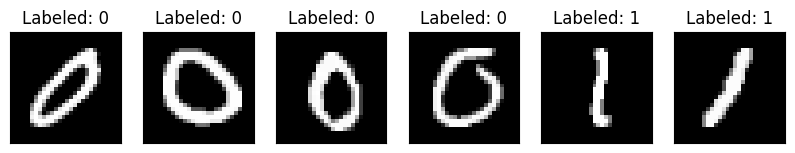

In [7]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

Similarly we create a test dataset from MNIST with digit 0 and 1 each with 50 samples

In [8]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

# Neural Network Model

Now we create our hybrid quantum neural network model with pytorch. WQe create this particular network with two convolutional layers, followed by a fully connected layer and a hybrid quantum circuit layer. 

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(np.pi / 2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

# Training

We create the training loop with negative log likelihood loss.

In [10]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

/tmp/ipykernel_10310/3704440015.py:24: DeprecationWarning: expectation_z() is deprecated, use expectation() with the same argument structure.
  expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z()
/tmp/ipykernel_10310/830442781.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  result = torch.tensor([expectation_z])
/home/u8283469/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA drive

Training [5%]	Loss: -1.1213
Training [10%]	Loss: -1.3461
Training [15%]	Loss: -1.3752
Training [20%]	Loss: -1.4005
Training [25%]	Loss: -1.4100
Training [30%]	Loss: -1.4114
Training [35%]	Loss: -1.4160
Training [40%]	Loss: -1.4352
Training [45%]	Loss: -1.4284
Training [50%]	Loss: -1.4541
Training [55%]	Loss: -1.4539
Training [60%]	Loss: -1.4497
Training [65%]	Loss: -1.4601
Training [70%]	Loss: -1.4709
Training [75%]	Loss: -1.4660
Training [80%]	Loss: -1.4675
Training [85%]	Loss: -1.4757
Training [90%]	Loss: -1.4742
Training [95%]	Loss: -1.4811
Training [100%]	Loss: -1.4724


Text(0, 0.5, 'Neg Log Likelihood Loss')

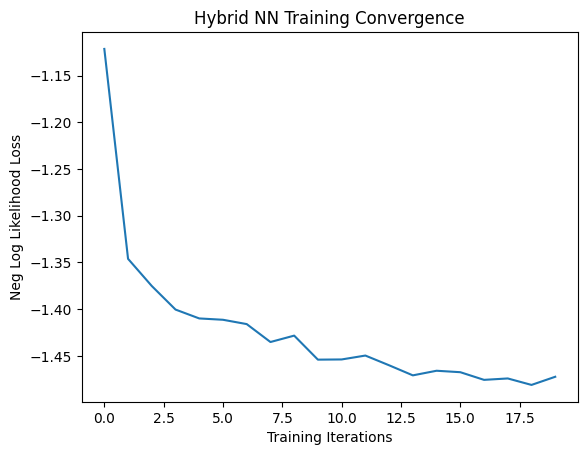

In [11]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# Test

Now we test the trained model with the test dataset by output its loss and accuracy.

In [12]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

/tmp/ipykernel_10310/3704440015.py:24: DeprecationWarning: expectation_z() is deprecated, use expectation() with the same argument structure.
  expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z()


Performance on test data:
	Loss: -1.4491
	Accuracy: 100.0%


/tmp/ipykernel_10310/3704440015.py:24: DeprecationWarning: expectation_z() is deprecated, use expectation() with the same argument structure.
  expectation = cudaq.observe(self.kernel, spin.z(0), thetas).expectation_z()


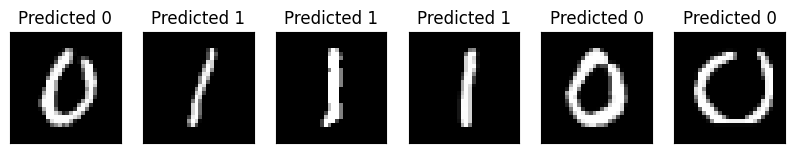

In [13]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1